#COMP 137 Final Project
Ethan Oliver

In [ ]:
import tensorflow as tf
import requests
print(tf.__version__)
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

2.4.0


In [ ]:
!cp /content/drive/MyDrive/deep_learning/tiny-imagenet-200.zip .
!unzip /content/tiny-imagenet-200.zip

In [ ]:
#load in data into Keras generators
from functools import partial

def get_df(labels_path):
    test_df = pd.read_csv(labels_path, sep='\t', index_col=None, header=None)
    test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
    return test_df

def load_data(batch_size, im_size):
    image_gen = ImageDataGenerator(samplewise_center=False)
    
    # Training data
    training_flow_func = partial(
        image_gen.flow_from_directory, 
        directory=os.path.join('/content','tiny-imagenet-200', 'train'), 
        target_size=im_size, classes=None,
        class_mode='categorical', batch_size=batch_size, 
        shuffle=False)
    
    # Training data subset
    train_gen = training_flow_func(subset='training')

    # Test data from validation dataset
    test_df = get_df(os.path.join('/content','tiny-imagenet-200',  'val', 'val_annotations.txt'))
    test_gen = image_gen.flow_from_dataframe(
        test_df, directory=os.path.join('/content','tiny-imagenet-200',  'val', 'images'), target_size=im_size, classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    return train_gen, test_gen
       
batch_size = 100
im_size = (224,224)

train_gen, test_gen = load_data(batch_size, im_size)

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

K.clear_session()

def get_inception_densenet_pretrained():
    model = Sequential([
        Input(shape=(224,224,3)),
        DenseNet121(include_top=False, pooling='avg'),
        Dropout(0.5),
        Dense(200, activation='softmax')
    ])

    loss = tf.keras.losses.CategoricalCrossentropy()
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model 

model_dense = get_inception_densenet_pretrained()
model_dense.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau

n_epochs=20

checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_best_only=False)


# Callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=25)
lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)
csv_logger = CSVLogger(os.path.join('/content/drive/MyDrive/deep_learning','training.log'))
history = dense_model.fit(
    train_gen, validation_data=valid_gen, batch_size),
    epochs=n_epochs, callbacks=[es_callback, lr_callback, csv_logger])

In [ ]:
#pretrained dense_model
dense_model = load_model("/content/drive/MyDrive/deep_learning/dense_post_model")

In [ ]:
# Evaluate the model
test_res = dense_model.evaluate(test_gen)

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(dense_model.metrics_names, test_res))
print(test_res_dict)

250/250 [==============================] - 13s 51ms/step - loss: 1.2701 - accuracy: 0.7369
{'loss': 1.2700589895248413, 'accuracy': 0.7368999719619751}


In [ ]:
!cp /content/drive/MyDrive/deep_learning/4_eval_resnet_pretrained.log .

['/content/4_eval_resnet_pretrained.log']


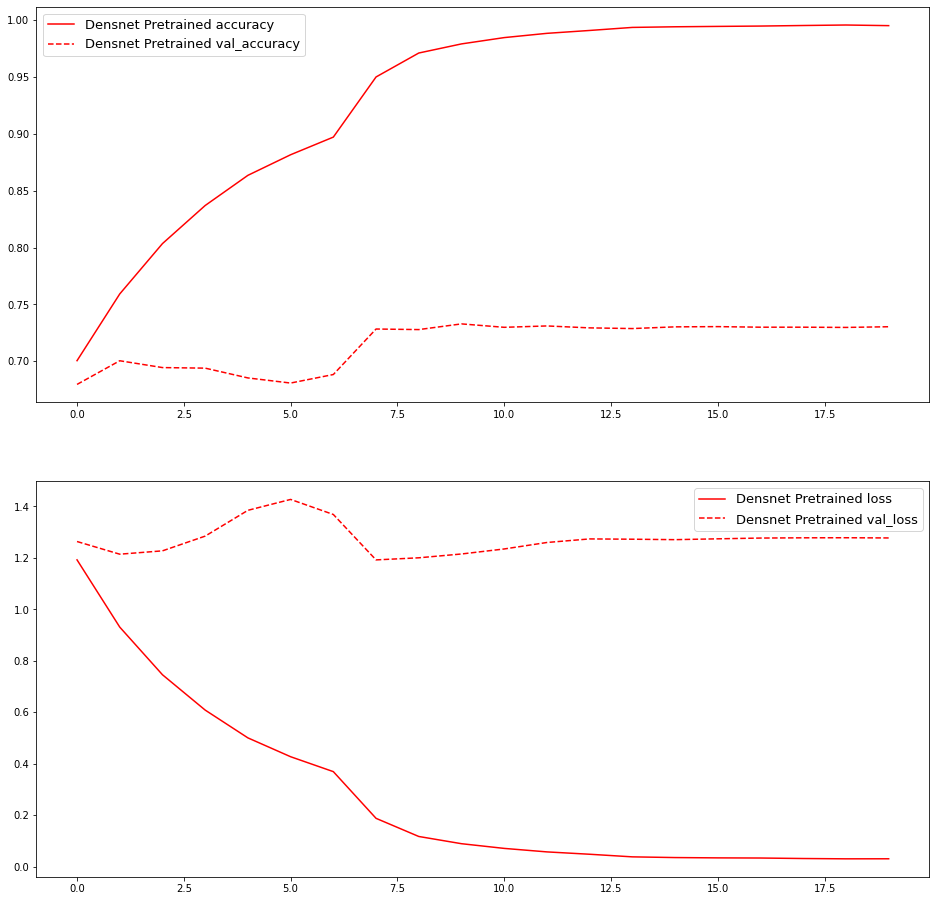

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(files, metrics, labels=None, linestyles=None, marker_styles=None, colors=None):
    data = {}    
    
    for i, f in enumerate(files):
        df = pd.read_csv(f, header=0, index_col=0)        
        if labels is not None:
            data[labels[i]] = df
        else:
            data[f] = df
            
    fig, axes = plt.subplots(len(metrics), 1, figsize=(16,16))
    
    for m, ax in zip(metrics, axes):        
        met_df = []
        for i, (lbl, df) in enumerate(data.items()):
            train_m, val_m = None, None
            for c in df.columns:
                if m in c and 'val' not in c:
                    train_m = c
                elif m in c and 'val' in c:
                    val_m = c
                    
          
                ax.plot(df.index, df[train_m], linestyle=linestyles[0], color=colors[i], label=lbl+' '+train_m)
                ax.plot(df.index, df[val_m], linestyle=linestyles[1], color=colors[i], label=lbl+' '+val_m)
                ax.plot(df.index, df[train_m], label=lbl)
                ax.plot(df.index, df[val_m], label=lbl)
        ax.legend(fontsize=13)
    
files = ["/content/training.log"]  
print(files)
metrics = ['accuracy', 'loss']
linestyles= ['-', '--']
labels = ['Densnet Pretrained']
colors = ['r', 'g', 'b', 'purple']
plot_metrics(files, metrics, labels, linestyles=linestyles, colors=colors)